# [2차 EDA] 1차 선별기업에 대한 추가작업 (아람&윤지) 
### 1. 작업 방향
- 1차 선별기업별 매출액 증가율 계산
- 연평균 20% 이상 성장 기업 기준 정렬 및 순위 정렬
- 추가 조건 선별 기업 시각화 진행

### 2. 선별 기업 리스트

> 연매출액 100억 이상 조건 : [126814, 294387, 294337, 294367, 126538, 126674, 126664, 126983, 227414, 126606, 126831, 227415, 403359, 403434, 469458, 126802, 419945, 403462, 469677, 420046]

> 연매출액 100억 & 직원수 30명 이상 조건 : [294387, 294337, 294367, 126538, 126664, 126983, 227414, 227415, 403359, 469458, 126802, 469677]

### 3. 연평균 매출액 증가율 기준 상위 5개 기업 선정
- 연 평균 매출액 20% 이상 성장 기업 : 294337, 469677
- 연 평균 매출액 15% 이상 성장 기업 : 420046, 126802
- 후 순위 : 294367 (성장률 14.402400%)

### 기타] 국민연금 인당금액 산정
- 인당 금액은 단순 계산 방식으로 진행 (월별 연금보험료 / 직원수) 

> 월 국민연금 납부액은 기준소득월액의 9%(사업주와 개인이 4.5%씩 부담)

    - 2020년 기준소득월액 상한액 : 503만원
    - 국민연금 보험료 최고 452,700원 

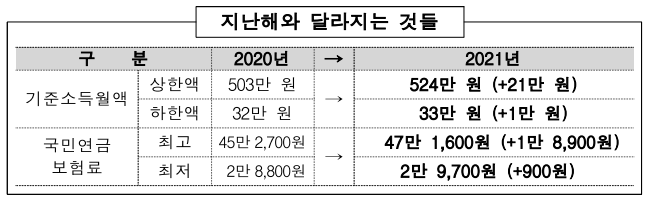

In [1]:
import pandas as pd 
import numpy as np 
#시각화
import matplotlib.pyplot as plt
import seaborn as sns
#경고무시
import sys
import warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야함.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨짐.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

In [3]:
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family 라는 변수에 할당.
a = get_font_family()
# 폰트설정
import matplotlib.pyplot as plt 
plt.rc("font", family = a)
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)
# ggplot으로 그래프 스타일 설정 / 개인 자유
plt.style.use("ggplot")

## 원본 데이터 불러오기

In [4]:
import pandas as pd

df = pd.read_csv('./company_nps_data.csv', encoding='cp949')
df

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5
2,342124,3221341,2018,7,781180,4
3,386420,4815584,2015,11,3795900,14
4,129243,9799736,2018,10,40724680,151
...,...,...,...,...,...,...
99796,171439,4630622,2017,2,2402740,11
99797,239388,1045021,2018,10,1428800,9
99798,272304,181898,2018,3,392560,4
99799,362194,2100218,2018,12,874780,3


# 함수 정의

In [5]:
# 매출액 증가율 함수
# (공식) 매출액증가율(%) = (당기매출액-전기매출액)/전기매출 *100
def sales_up_rate(company_id):
    temp = df.loc[df['회사ID'] == company_id, :]

    # '회사ID', '년도', '월' 기준으로 오름차순 정렬한 데이터프레임 생성 
    sorted_df = temp.sort_values(by=['회사ID', '년도', '월'], axis=0)
    sorted_df.reset_index(drop=True, inplace=True)

    # 회사 id별로 매출액 증가율 계산 
    sales_rate = sorted_df.drop_duplicates(['연매출액'], keep = 'first')
    sales_rate['매출액증가율'] = 0
    for i in range(1, len(sales_rate)):
        sales_rate['매출액증가율'].iloc[i] = round((sales_rate['연매출액'].iloc[i]-sales_rate['연매출액'].iloc[i-1])
        /sales_rate['연매출액'].iloc[i-1]*100, 4)
    
    # 필요없는 컬럼 정리
    sales_rate.drop(['월', '월별_연금보험료', '월별_직원수'], axis=1, inplace=True)

    #최종 데이터 프레임 리턴
    return sales_rate  # 데이터 프레임 리턴 

In [6]:
def add_ym(company_id):
    # 기업별 자료 추출 및 데이터 정렬
    com = df.loc[df['회사ID'] == company_id, :]
    com.sort_values(by=['년도', '월'], axis=0, inplace=True)
    com.reset_index(drop=True, inplace=True)

    # 년월 파생변수 만들어주기 
    년월 = com['년도'].map(str) + "-" + com['월'].map(str) #연도와 월 합침
    com.insert(2, '년월',년월)

    # 인당 연금보험료 파생변수 만들어주기(연금보험료/직원수)
    # 국민연금은 급여의 4.5%를 근로자와 사업주가 각각 공제
    인당_연금보험료 = round(com['월별_연금보험료']/com['월별_직원수'], 2)
    com.insert(7, '인당_연금보험료',인당_연금보험료)

    # (파생변수 추가+정렬)된 데이터프레임 리턴
    return com

In [7]:
# 해당 기업만 데이터 뽑아 정리
df_126802 = add_ym(126802)
df_126802.head()

,회사ID,연매출액,년월,년도,월,월별_연금보험료,월별_직원수,인당_연금보험료
0,126802,80102292,2015-11,2015,11,102069980,393,259720.05
1,126802,80102292,2015-12,2015,12,101544500,394,257727.16
2,126802,81859588,2016-1,2016,1,102730640,400,256826.60
3,126802,81859588,2016-2,2016,2,103285860,403,256292.46
4,126802,81859588,2016-3,2016,3,104091680,406,256383.45


# 기존에 진행했던 방식

In [8]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
data = df_126802[['연매출액','월별_연금보험료','월별_직원수']].corr()
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.287614,0.387994
월별_연금보험료,0.287614,1.000000,0.946563
월별_직원수,0.387994,0.946563,1.000000


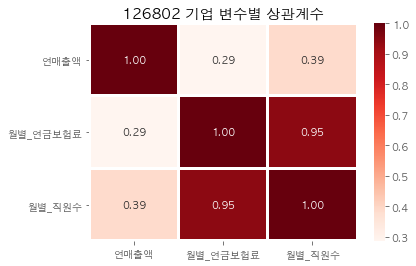

In [9]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126802 기업 변수별 상관계수')
plt.show()

# 스케일링 후 corr()적용

In [19]:
# '연매출액','월별_연금보험료','월별_직원수' 에 따른 상관계수
from sklearn.preprocessing import StandardScaler
data = df_126802[['연매출액','월별_연금보험료','월별_직원수']]
standardScaler = StandardScaler()
data = standardScaler.fit_transform(data)  #StandardScaler 적용
data = pd.DataFrame(data, columns=['연매출액','월별_연금보험료','월별_직원수'])  # 결과 배열 데이터프레임으로 변환
data = data.corr() 
data

,연매출액,월별_연금보험료,월별_직원수
연매출액,1.000000,0.287614,0.387994
월별_연금보험료,0.287614,1.000000,0.946563
월별_직원수,0.387994,0.946563,1.000000


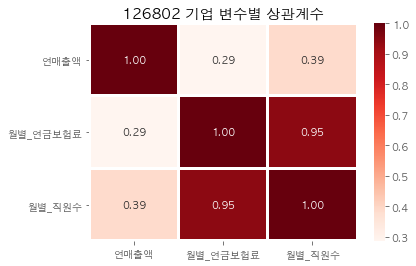

In [20]:
# 상관계수 히트맵 
sns.heatmap(data=data, cmap="Reds", annot=True, fmt=".2f", linewidths=2)
plt.title('126802 기업 변수별 상관계수')
plt.show()

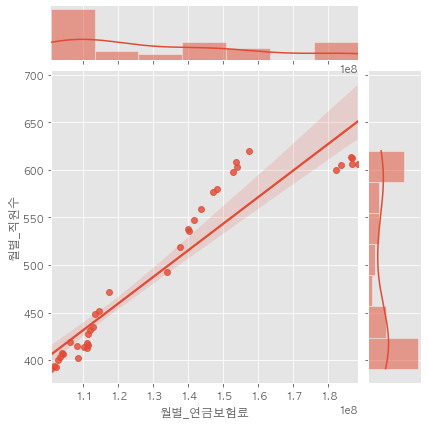

In [23]:
sns.jointplot(x='월별_연금보험료', y='월별_직원수', data=df_126802, kind='reg')

In [17]:
# 매출액 증가율 계산 
sales_126814 = sales_up_rate(126814) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126814

,회사ID,연매출액,년도,매출액증가율
0,126814,421492545,2015,0.0000
2,126814,399262755,2016,-5.2741
14,126814,625604516,2017,56.6899
26,126814,627641511,2018,0.3256


In [18]:
# 평균 매출 증가율
sales_126814['매출액증가율'].mean()
print('126814 기업 연평균 매출 증가율 {}'.format(round(sales_126814['매출액증가율'].mean(), 2)))

126814 기업 연평균 매출 증가율 12.94


In [19]:
# 매출액 증가율 계산 
sales_294387 = sales_up_rate(294387) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_294387

,회사ID,연매출액,년도,매출액증가율
0,294387,132543154,2015,0.0000
2,294387,153057557,2016,15.4775
14,294387,150451803,2017,-1.7025
26,294387,168291675,2018,11.8575


In [20]:
# 평균 매출 증가율
sales_294387['매출액증가율'].mean()
print('294387 기업 연평균 매출 증가율 {}'.format(round(sales_294387['매출액증가율'].mean(), 2)))

294387 기업 연평균 매출 증가율 6.41


In [21]:
# 매출액 증가율 계산 
sales_294337 = sales_up_rate(294337) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_294337

,회사ID,연매출액,년도,매출액증가율
0,294337,102579741,2015,0.0000
2,294337,146274359,2016,42.5958
14,294337,192586665,2017,31.6613
26,294337,287134819,2018,49.0938


In [22]:
# 평균 매출 증가율
sales_294337['매출액증가율'].mean()
print('294337 기업 연평균 매출 증가율 {}'.format(round(sales_294337['매출액증가율'].mean(), 2)))

294337 기업 연평균 매출 증가율 30.84


In [23]:
# 매출액 증가율 계산 
sales_126521 = sales_up_rate(126521) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126521

,회사ID,연매출액,년도,매출액증가율
0,126521,567910907,2015,0.0000
2,126521,560278128,2016,-1.3440
14,126521,554767229,2017,-0.9836
26,126521,567246558,2018,2.2495


In [24]:
# 평균 매출 증가율
sales_126521['매출액증가율'].mean()
print('126521 기업 연평균 매출 증가율 {}'.format(round(sales_126521['매출액증가율'].mean(), 2)))

126521 기업 연평균 매출 증가율 -0.02


In [25]:
# 매출액 증가율 계산 
sales_294367 = sales_up_rate(294367) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_294367

,회사ID,연매출액,년도,매출액증가율
0,294367,601303965,2015,0.0000
2,294367,535249090,2016,-10.9853
14,294367,633160910,2017,18.2928
26,294367,875661976,2019,38.3001


In [26]:
# 평균 매출 증가율
sales_294367['매출액증가율'].mean()
print('294367 기업 연평균 매출 증가율 {}'.format(round(sales_294367['매출액증가율'].mean(), 2)))

294367 기업 연평균 매출 증가율 11.4


In [27]:
# 매출액 증가율 계산 
sales_126538 = sales_up_rate(126538) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126538

,회사ID,연매출액,년도,매출액증가율
0,126538,605381377,2015,0.0000
2,126538,671580655,2016,10.9351
14,126538,716851120,2017,6.7409
26,126538,721901349,2018,0.7045


In [28]:
# 평균 매출 증가율
sales_126538['매출액증가율'].mean()
print('126538 기업 연평균 매출 증가율 {}'.format(round(sales_126538['매출액증가율'].mean(), 2)))

126538 기업 연평균 매출 증가율 4.6


In [29]:
# 매출액 증가율 계산 
sales_439986 = sales_up_rate(439986) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_439986

,회사ID,연매출액,년도,매출액증가율
0,439986,141545112,2015,0.0000
2,439986,24165040,2016,-82.9277
14,439986,22658277,2018,-6.2353


In [30]:
# 평균 매출 증가율
sales_439986['매출액증가율'].mean()
print('439986 기업 연평균 매출 증가율 {}'.format(round(sales_439986['매출액증가율'].mean(), 2)))

439986 기업 연평균 매출 증가율 -29.72


In [31]:
# 매출액 증가율 계산 
sales_126674 = sales_up_rate(126674) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126674

,회사ID,연매출액,년도,매출액증가율
0,126674,474963360,2015,0.0000
2,126674,480114248,2016,1.0845
14,126674,531267060,2017,10.6543
26,126674,524068949,2018,-1.3549


In [32]:
# 평균 매출 증가율
sales_126674['매출액증가율'].mean()
print('126674 기업 연평균 매출 증가율 {}'.format(round(sales_126674['매출액증가율'].mean(), 2)))

126674 기업 연평균 매출 증가율 2.6


In [33]:
# 매출액 증가율 계산 
sales_126516 = sales_up_rate(126516) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126516

,회사ID,연매출액,년도,매출액증가율
0,126516,1061715908,2015,0.0000
2,126516,468913812,2016,-55.8343
14,126516,402601664,2017,-14.1416


In [34]:
# 평균 매출 증가율
sales_126516['매출액증가율'].mean()
print('126516 기업 연평균 매출 증가율 {}'.format(round(sales_126516['매출액증가율'].mean(), 2)))

126516 기업 연평균 매출 증가율 -23.33


In [35]:
# 매출액 증가율 계산 
sales_507086 = sales_up_rate(507086) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_507086

,회사ID,연매출액,년도,매출액증가율
0,507086,80680852,2015,0.0000
2,507086,18652340,2016,-76.8813
14,507086,20186195,2017,8.2234
26,507086,18281261,2018,-9.4368


In [36]:
# 평균 매출 증가율
sales_507086['매출액증가율'].mean()
print('507086 기업 연평균 매출 증가율 {}'.format(round(sales_507086['매출액증가율'].mean(), 2)))

507086 기업 연평균 매출 증가율 -19.52


In [37]:
# 매출액 증가율 계산 
sales_126664 = sales_up_rate(126664) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126664

,회사ID,연매출액,년도,매출액증가율
0,126664,256505233,2015,0.0000
2,126664,304408150,2016,18.6752
14,126664,323278620,2017,6.1991
26,126664,353839107,2018,9.4533


In [38]:
# 평균 매출 증가율
sales_126664['매출액증가율'].mean()
print('126664 기업 연평균 매출 증가율 {}'.format(round(sales_126664['매출액증가율'].mean(), 2)))

126664 기업 연평균 매출 증가율 8.58


In [39]:
# 매출액 증가율 계산 
sales_403351 = sales_up_rate(403351) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_403351

,회사ID,연매출액,년도,매출액증가율
0,403351,470467863,2015,0.0000
2,403351,475019162,2016,0.9674
14,403351,430240720,2017,-9.4267
26,403351,415269293,2018,-3.4798


In [40]:
# 평균 매출 증가율
sales_403351['매출액증가율'].mean()
print('403351 기업 연평균 매출 증가율 {}'.format(round(sales_403351['매출액증가율'].mean(), 2)))

403351 기업 연평균 매출 증가율 -2.98


In [41]:
# 매출액 증가율 계산 
sales_126983 = sales_up_rate(126983) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126983

,회사ID,연매출액,년도,매출액증가율
0,126983,119119899,2015,0.0000
2,126983,144618199,2016,21.4056
14,126983,151335859,2017,4.6451
26,126983,195570294,2018,29.2293


In [42]:
# 평균 매출 증가율
sales_126983['매출액증가율'].mean()
print('126983 기업 연평균 매출 증가율 {}'.format(round(sales_126983['매출액증가율'].mean(), 2)))

126983 기업 연평균 매출 증가율 13.82


In [43]:
# 매출액 증가율 계산 
sales_227414 = sales_up_rate(227414) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_227414

,회사ID,연매출액,년도,매출액증가율
0,227414,4047655229,2015,0.0000
2,227414,4210897523,2016,4.0330
14,227414,4644329868,2017,10.2931
26,227414,4933525226,2018,6.2268


In [44]:
# 평균 매출 증가율
sales_227414['매출액증가율'].mean()
print('227414 기업 연평균 매출 증가율 {}'.format(round(sales_227414['매출액증가율'].mean(), 2)))

227414 기업 연평균 매출 증가율 5.14


In [45]:
# 매출액 증가율 계산 
sales_126606 = sales_up_rate(126606) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126606

,회사ID,연매출액,년도,매출액증가율
0,126606,937184426,2015,0.0000
2,126606,980566803,2016,4.6290
14,126606,1031422825,2017,5.1864
26,126606,1035707054,2018,0.4154


In [46]:
# 평균 매출 증가율
sales_126606['매출액증가율'].mean()
print('126606 기업 연평균 매출 증가율 {}'.format(round(sales_126606['매출액증가율'].mean(), 2)))

126606 기업 연평균 매출 증가율 2.56


In [47]:
# 매출액 증가율 계산 
sales_126831 = sales_up_rate(126831) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_126831

,회사ID,연매출액,년도,매출액증가율
0,126831,2000958572,2015,0.0000
2,126831,1753200162,2016,-12.3820
14,126831,2102007007,2017,19.8954
26,126831,2206140616,2018,4.9540


In [48]:
# 평균 매출 증가율
sales_126831['매출액증가율'].mean()
print('126831 기업 연평균 매출 증가율 {}'.format(round(sales_126831['매출액증가율'].mean(), 2)))

126831 기업 연평균 매출 증가율 3.12


In [49]:
# 매출액 증가율 계산 
sales_510329 = sales_up_rate(510329) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_510329

,회사ID,연매출액,년도,매출액증가율
0,510329,149770456,2015,0.0000
2,510329,136264259,2016,-9.0179
14,510329,134718002,2017,-1.1347
26,510329,143513683,2018,6.5290


In [50]:
# 평균 매출 증가율
sales_510329['매출액증가율'].mean()
print('510329 기업 연평균 매출 증가율 {}'.format(round(sales_510329['매출액증가율'].mean(), 2)))

510329 기업 연평균 매출 증가율 -0.91


In [51]:
# 매출액 증가율 계산 
sales_227415 = sales_up_rate(227415) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_227415

,회사ID,연매출액,년도,매출액증가율
0,227415,4961710828,2015,0.0000
2,227415,5093598465,2016,2.6581
14,227415,5387846478,2017,5.7768
26,227415,5521038494,2018,2.4721


In [52]:
# 평균 매출 증가율
sales_227415['매출액증가율'].mean()
print('227415 기업 연평균 매출 증가율 {}'.format(round(sales_227415['매출액증가율'].mean(), 2)))

227415 기업 연평균 매출 증가율 2.73


In [53]:
# 매출액 증가율 계산 
sales_403359 = sales_up_rate(403359) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_403359

,회사ID,연매출액,년도,매출액증가율
0,403359,132314221,2015,0.0000
2,403359,140810131,2016,6.4210
14,403359,147618546,2017,4.8352
26,403359,156550808,2018,6.0509


In [54]:
# 평균 매출 증가율
sales_403359['매출액증가율'].mean()
print('403359 기업 연평균 매출 증가율 {}'.format(round(sales_403359['매출액증가율'].mean(), 2)))

403359 기업 연평균 매출 증가율 4.33


In [55]:
# 매출액 증가율 계산 
sales_403434 = sales_up_rate(403434) # 연도별 매출액과 매출액 증가율 담은 데이터프레임 생성
sales_403434

,회사ID,연매출액,년도,매출액증가율
0,403434,139353875,2015,0.0000
2,403434,147323098,2016,5.7187
14,403434,150446694,2017,2.1202
26,403434,169810428,2018,12.8708


In [56]:
# 평균 매출 증가율
sales_403434['매출액증가율'].mean()
print('403434 기업 연평균 매출 증가율 {}'.format(round(sales_403434['매출액증가율'].mean(), 2)))

403434 기업 연평균 매출 증가율 5.18
